# Using Pearl to solve Gymnasium's Lunar Lander with DQN and PPO in discrete and continuous action spaces

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/lunar_lander/lunaer_lander.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

This example shows how to use both DQN and PPO to solve the `LunarLander-v2` environment from gymnasium in discrete and continuous action spaces. 

In [ ]:
from sympy.utilities.lambdify import NUMPY
%load_ext autoreload
%autoreload 2

# Pearl Installation

If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.



In [ ]:
# Pearl installation from github. This install also includes PyTorch, Gym and Matplotlib

%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git

In [ ]:
%cd Pearl
%pip install .
%cd ..

In [1]:
!pip install swig

In [ ]:
# Gymnasium 0.29.1 does not support Numpy 2+ right now. Either downgrade numpy to version 1+ or wait for Gymnasium 1+
# https://github.com/Farama-Foundation/Gymnasium/issues/1142
#!pip install numpy==1.26.4

In [2]:
!pip install "gymnasium[box2d]"

# Import Modules

In [1]:
import torch
import numpy as np
import gymnasium
import platform
import matplotlib.pyplot as plt

from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.policy_learners.sequential_decision_making.double_dqn import DoubleDQN
from pearl.policy_learners.sequential_decision_making.ppo import ProximalPolicyOptimization
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.policy_learners.exploration_modules.common.epsilon_greedy_exploration import EGreedyExploration
from pearl.replay_buffers.sequential_decision_making.on_policy_replay_buffer import OnPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.policy_learners.sequential_decision_making.ppo_continuous import ContinuousProximalPolicyOptimization
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)

from importlib.metadata import version

set_seed(0)

In [2]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Pearl Version: {version('pearl')}")

Python Version: 3.10.14
Torch Version: 2.4.0
Is Cuda Available: False
Cuda Version: None
Gymnasium Version: 0.29.1
Numpy Version: 1.26.4
Pearl Version: 0.1.0


# CarPole-v1

In [ ]:
env_str = "CartPole-v1"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

## Double DQN


In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]

# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=env.action_space.n,             # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DoubleDQN` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_value_network,   # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
)

# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns
info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")
plt.plot(np.arange(len(info_DoubleDQN["return"])),
         info_DoubleDQN["return"],
         label="DoubleDQN")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

## Proximal Policy Optimization (PPO)

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        batch_size=64,
        training_rounds=10,
        critic_learning_rate=1e-3,
        actor_learning_rate=1e-3,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_episodes=750,
    print_every_x_episodes=50,
    learn_after_episode=True,
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# LunarLander-v2

In [3]:
env_str = "LunarLander-v2"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

Gym Environment: LunarLander-v2
Observation Space: 8
Number of Actions: 4
Action Space Dimensions: 1
Is Action Space Continuous: False


## Double DQN

In [4]:
# Create Environment
env = GymEnvironment(env_str)

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]


# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=env.action_space.n,             # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

# Create Pearl Agent
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        network_instance=Q_value_network,   # pass an instance of Q value network to the policy learner.
        exploration_module=EGreedyExploration(0.025),
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(1_000_000),
)

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=3000,
    print_every_x_episodes=50,   # print returns after every 50 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    record_period=50,
    seed=0
)

env.close()

episode 50, step 6305, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -17.513270324096084
episode 100, step 54296, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -80.4936675929057
episode 150, step 88086, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -65.75366778695025
episode 200, step 126132, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -97.58207880938426
episode 250, step 173051, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -31.785672722384334
episode 300, step 214651, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -28.959872663021088
episode 350, step 254356, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -84.23235457178089
episode 400, step 296218, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayB

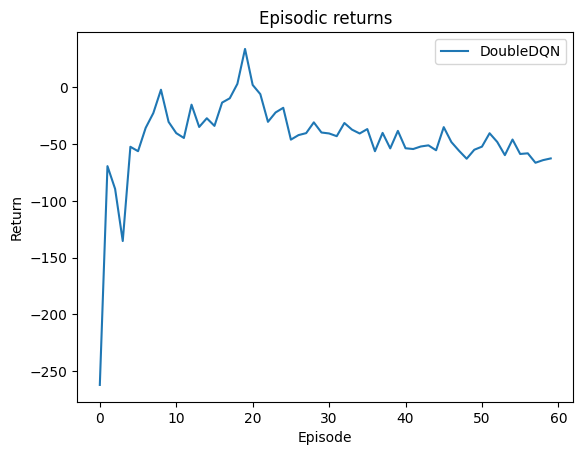

In [5]:
# info["return"] refers to the episodic returns
torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")
plt.plot(np.arange(len(info_DoubleDQN["return"])),
         info_DoubleDQN["return"],
         label="DoubleDQN")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

## Proximal Policy Optimization (PPO) - Discrete Action Spaces

In [6]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
# ProximalPolicyOptimization defaults the exploration module to PropensityExploration
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=1e-4,
        actor_learning_rate=1e-4,
        epsilon=0.2,
        batch_size=128,
        training_rounds=10,
        entropy_bonus_scaling=0.01,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    #number_of_episodes=1000,
    number_of_steps=2_000_000,
    print_every_x_episodes=100,
    #print_every_x_steps=2048,
    learn_every_k_steps=2048,
    record_period=10_000,
    learn_after_episode=False,
    seed=0
)

env.close()

/Users/michaelkudlaty/anaconda3/envs/PPOPearl/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


episode 100, step 9997, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -142.6342160294298
episode 200, step 19160, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -414.4543406572193
episode 300, step 28320, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -216.1193455979228
episode 400, step 37686, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -236.6198745779693
episode 500, step 48123, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -133.11162795033306
episode 600, step 57473, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -108.81420477177016
episode 700, step 66759, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -370.914965793490

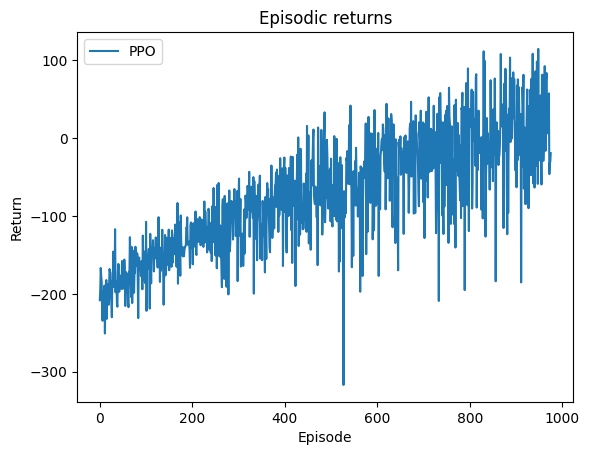

In [7]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# LunarLanderContinuous-v2

In [8]:
env_str = "LunarLanderContinuous-v2"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.shape[0]}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

Gym Environment: LunarLanderContinuous-v2
Observation Space: 8
Number of Actions: 2
Action Space Dimensions: 2
Is Action Space Continuous: True


In [9]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
# ContinuousProximalPolicyOptimization defaults the exploration module to PropensityExploration
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=1e-4,
        actor_learning_rate=1e-4,
        epsilon=0.2,
        batch_size=128,
        normalize_gae=False,
        training_rounds=10,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=10_000,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 11002, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -316.2420981153846
episode 200, step 22518, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -105.07268190197647
episode 300, step 33424, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -68.29445032775402
episode 400, step 45476, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -100.41077865590341
episode 500, step 57460, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -164.1527540741954
episode 600, step 69210, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -360.5535676339641
episode 700, step 81

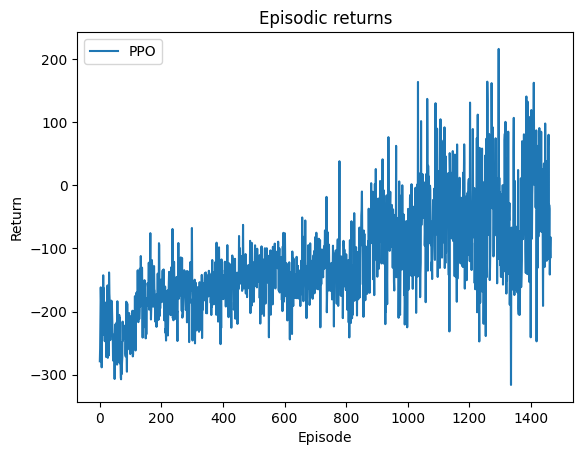

In [10]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [11]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=1e-4,
        actor_learning_rate=1e-4,
        epsilon=0.2,
        batch_size=64,
        normalize_gae=False,
        training_rounds=10,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=10_000,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 9356, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -635.0749513357878
episode 200, step 18984, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -81.48301302827895
episode 300, step 27994, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -77.74317195266485
episode 400, step 37432, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -86.83215184509754
episode 500, step 46295, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -626.6261762622744
episode 600, step 55858, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -124.9573248885572
episode 700, step 65406

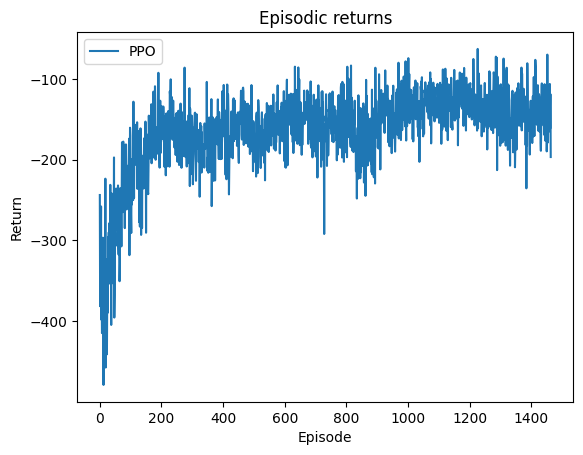

In [12]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [13]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=3e-4,
        actor_learning_rate=3e-4,
        epsilon=0.2,
        batch_size=128,
        normalize_gae=False,
        training_rounds=10,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=10_000,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 10113, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -301.7195637850091
episode 200, step 21296, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -82.45677979290485
episode 300, step 31201, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -115.48230804875493
episode 400, step 41589, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -281.34909414872527
episode 500, step 52665, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -168.4882938079536
episode 600, step 63379, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -333.2287816852331
episode 700, step 75

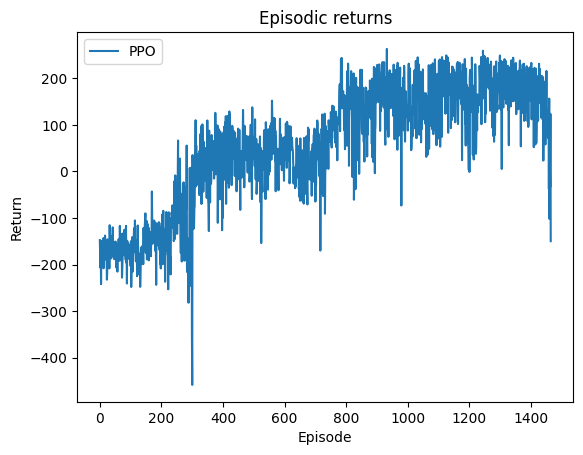

In [14]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [15]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=3e-4,
        actor_learning_rate=3e-4,
        epsilon=0.2,
        batch_size=128,
        normalize_gae=False,
        training_rounds=20,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=10_000,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 10419, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -105.62363199656829
episode 200, step 20391, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -101.80050723068416
episode 300, step 30256, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -62.8151508718729
episode 400, step 40696, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -172.92247085925192
episode 500, step 51993, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -33.855457969009876
episode 600, step 63597, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -140.1233346988447
episode 700, step 7

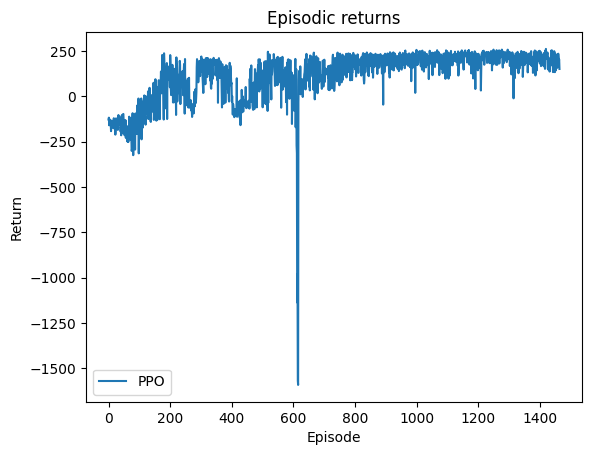

In [16]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [17]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ContinuousProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=3e-4,
        actor_learning_rate=3e-4,
        epsilon=0.2,
        batch_size=128,
        normalize_gae=True,
        training_rounds=20,
        entropy_bonus_scaling=0.005,
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_steps=3_000_000,
    print_every_x_episodes=100,
    learn_every_k_steps=2048,
    record_period=2048,
    learn_after_episode=False,
    seed=0
)

env.close()

episode 100, step 12448, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -231.68058259785175
episode 200, step 25138, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -107.6685210808646
episode 300, step 39098, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -124.42471128515899
episode 400, step 52010, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -256.9194538369775
episode 500, step 70328, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -186.12177002429962
episode 600, step 90111, agent=PearlAgent with ContinuousProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLanderContinuous-v2
return: -385.77037026407197
episode 700, step 

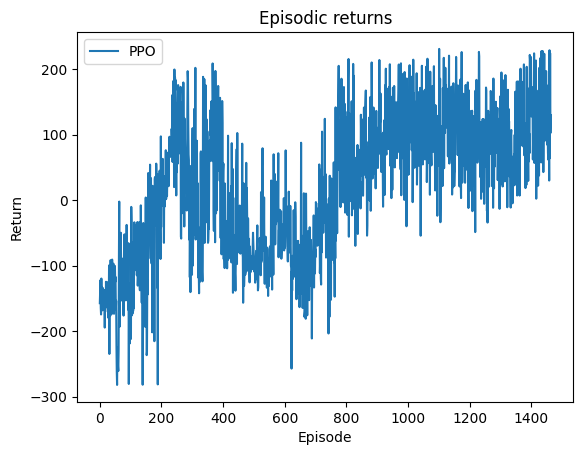

In [18]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()